<a href="https://colab.research.google.com/github/CharlotteBenadiba/Improving-Transferability-with-GAN/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Offensive AI - Final Project

Improving Transferability with GAN

Student: Wei Wu (850023680)

Student: Charlotte Benadiba (20DA15380)

Date: Jan 18. 2023

Notebook Overview:
1. Definitions of Neural Networks
   a. Target Models
   b. Dicriminator and Generator
2. Training Target Models
3. Adv_GAN Attack with input diversity
4. Attacking Target Models
5. Test the performance of Adv_GAN
6. Visualization of the results
7. Discussion

Code Setup:

In [ ]:
#import packages
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import os

Section 1: Definitions of Neural Networks

1.1 Target Models
In this section we are going to define the target models. There are three target models used in this project including two CNNs and a pre-trained ResNet50.
The architecture of the two CNNs are as the followings:
1. Conv-Relu -> Conv-Relu -> Maxpool -> Conv_Relu -> Conv_Relu -> Maxpool -> FullyConnectedLayer-Relu -> dropout -> FullyConnectedLayer_output_Relu

2. Conv-Relu -> Conv-Relu -> Maxpool -> dropout -> flatten -> FullyConnetedLayer-Relu -> dropout -> FullyConnectedLayer_output_Softmax

In [ ]:
#class object: MNIST_target_net
#Target Convolutional Network
class MNIST_target_net(nn.Module):
    def __init__(self):
        super(MNIST_target_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)

        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.logits = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = self.logits(x)
        return x

In [ ]:
#class object: MNIST_target_net_2
#Second target convolutional neural network
class MNIST_target_net_2(nn.Module):
    def __init__(self):
      super(MNIST_target_net_2, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)

    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

In [ ]:
#class object: MnistResNet
#Third Target model, pretrained ResNet
class MnistResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(MnistResNet, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)
    def forward(self, x):
        return self.model(x)


1.2: Discriminator and Generator
In this section we are going to build the Discriminator and the Generator in the Generative Adversarial NeuralNetwork.
The architecture of the Disctiminator is :
Conv -> LeakyRelu -> Conv ->BatchNorm -> LeakyRelu -> Conv-> BatchNorm-> LeakyRelu -> Conv -Sigmoid

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        # MNIST: 1*28*28
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            # 8*13*13
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # 16*5*5
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
            # 32*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output


Generator:The generator is to generate perturbations add to the images to create adversarial examples.

In [ ]:
#Class Object: Generator
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 28 x 28
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x


The ResnetBlock for the generator

In [ ]:
#Class Object: ResnetBlock
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

Section 2: Training Target Models

In [ ]:
#Define hyperparameters
use_cuda = True
image_nc = 1
batch_size = 128

# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
#load dataset
mnist_dataset = torchvision.datasets.MNIST('./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

# training the target model
#target_model = MNIST_target_net().to(device)
target_model = MNIST_target_net_2().to(device)
#target_model = MnistResNet().to(device)
target_model.train()
opt_model = torch.optim.Adam(target_model.parameters(), lr=0.001)
epochs = 40
for epoch in range(epochs):
    loss_epoch = 0
    #after first half, we change the learning rate
    if epoch == 20:
        opt_model = torch.optim.Adam(target_model.parameters(), lr=0.0001)
    for i, data in enumerate(train_dataloader, 0):
        train_imgs, train_labels = data
        train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
        logits_model = target_model(train_imgs)
        loss_model = F.cross_entropy(logits_model, train_labels)
        loss_epoch += loss_model
        opt_model.zero_grad()
        loss_model.backward()
        opt_model.step()
    print('loss in epoch %d: %f' % (epoch, loss_epoch.item()))

# save model
targeted_model_file_name = './MNIST_target_model_2.pth'
torch.save(target_model.state_dict(), targeted_model_file_name)
target_model.eval()

# MNIST test dataset
mnist_dataset_test = torchvision.datasets.MNIST('./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    pred_lab = torch.argmax(target_model(test_img), 1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('accuracy in testing set: %f\n'%(num_correct.item()/len(mnist_dataset_test)))

CUDA Available:  True
loss in epoch 0: 145.082428
loss in epoch 1: 49.439304
loss in epoch 2: 38.127514
loss in epoch 3: 33.526325
loss in epoch 4: 27.471724
loss in epoch 5: 24.161648
loss in epoch 6: 22.416456
loss in epoch 7: 20.626448
loss in epoch 8: 18.795126
loss in epoch 9: 16.790474
loss in epoch 10: 15.646844
loss in epoch 11: 15.408834
loss in epoch 12: 14.274240
loss in epoch 13: 12.991155
loss in epoch 14: 11.902868
loss in epoch 15: 10.697295
loss in epoch 16: 10.820408
loss in epoch 17: 10.236634
loss in epoch 18: 9.543758
loss in epoch 19: 8.713983
loss in epoch 20: 6.632321
loss in epoch 21: 6.231563
loss in epoch 22: 5.422671
loss in epoch 23: 5.299797
loss in epoch 24: 4.686753
loss in epoch 25: 4.636220
loss in epoch 26: 4.364882
loss in epoch 27: 4.302861
loss in epoch 28: 3.713274
loss in epoch 29: 3.925326
loss in epoch 30: 3.824445
loss in epoch 31: 3.275690
loss in epoch 32: 3.737580
loss in epoch 33: 3.716527
loss in epoch 34: 3.750410
loss in epoch 35: 3.8477

Section 3: AdvGAN-Input Diversity

In this section, we are going to build the AdvGan with input diversity. The input diversity is an idea from Improving Transferability of Adversarial Examples with Input Diversity, Xie et al. 2018, in which they consider random resizing and rescaling to improve transferability. The general idea is more or less the same thing. Therefore we apply input diversity to AdvGAN to improve transferability.

In [ ]:
#model dir
models_path = './models/'

In [ ]:
#function: weights_init
def weights_init(m):
    '''
    This function is to initialize weights.
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Function: input_diversity
def input_diversity(x, resize_rate=1.15, diversity_prob=0.7):
    '''
    Function: input_diversity
    Inputs:
    x, the input tensor of images
    resize_rate, the resize rate
    diversity_prob, probability of create diverse inputs
    Return:
    ret, image tensor
    '''
    assert resize_rate >= 1.0
    assert diversity_prob >= 0.0 and diversity_prob <= 1.0
    img_size = x.shape[-1]
    img_resize = int(img_size * resize_rate)
    rnd = torch.randint(low=img_size, high=img_resize, size=(1,), dtype=torch.int32)
    rescaled = F.interpolate(x, size=[rnd, rnd], mode='bilinear', align_corners=False)
    h_rem = img_resize -rnd
    w_rem = img_resize -rnd
    pad_top = torch.randint(low=0, high=h_rem.item(), size=(1,), dtype=torch.int32)
    pad_bottom = h_rem - pad_top
    pad_left = torch.randint(low=0, high=w_rem.item(), size=(1,), dtype=torch.int32)
    pad_right = w_rem - pad_left
    padded = F.pad(rescaled, [pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()], value=0)
    ret = padded if torch.rand(1) < diversity_prob else x
    return ret

In [ ]:
#class object: AdvGan_attack
#The class is to perform adversarial attack using GAN.
class AdvGAN_Attack:
    #initialize variables
    def __init__(self,
                 device,
                 model,
                 model_num_labels,
                 image_nc,
                 box_min,
                 box_max):
        output_nc = image_nc
        self.device = device
        self.model_num_labels = model_num_labels
        self.model = model
        self.input_nc = image_nc
        self.output_nc = output_nc
        self.box_min = box_min
        self.box_max = box_max

        self.gen_input_nc = image_nc
        self.netG = Generator(self.gen_input_nc, image_nc).to(device)
        self.netDisc =Discriminator(image_nc).to(device)

        # initialize all weights
        self.netG.apply(weights_init)
        self.netDisc.apply(weights_init)

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=0.001)
        self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                            lr=0.001)

        if not os.path.exists(models_path):
            os.makedirs(models_path)
    #method: input diversity with resizing, rescaling and random padding
    def input_diversity(self,x, resize_rate=1.15, diversity_prob=0.7):
        assert resize_rate >= 1.0
        assert diversity_prob >= 0.0 and diversity_prob <= 1.0
        img_size = x.shape[-1]
        img_resize = int(img_size * resize_rate)
        rnd = torch.randint(low=img_size, high=img_resize, size=(1,), dtype=torch.int32)
        rescaled = F.interpolate(x, size=[rnd, rnd], mode='bilinear', align_corners=False)
        h_rem = img_resize -rnd
        w_rem = img_resize -rnd
        pad_top = torch.randint(low=0, high=h_rem.item(), size=(1,), dtype=torch.int32)
        pad_bottom = h_rem - pad_top
        pad_left = torch.randint(low=0, high=w_rem.item(), size=(1,), dtype=torch.int32)
        pad_right = w_rem - pad_left
        padded = F.pad(rescaled, [pad_left.item(), pad_right.item(), pad_top.item(), pad_bottom.item()], value=0)
        ret = padded if torch.rand(1) < diversity_prob else x
        return ret
    #method train_batch
    def train_batch(self, x, labels):
        # optimize D
        for i in range(1):
            perturbation = self.netG(x)
            perturbation = torch.clamp(perturbation, -0.3, 0.3)
            adv_images = x + perturbation
            adv_images = torch.clamp(adv_images, self.box_min, self.box_max)
            adv_images = self.input_diversity(adv_images)
            adv_images = transform(adv_images)
            adv_images = F.interpolate(adv_images, size=[28,28], mode='bilinear', align_corners=False)

            self.optimizer_D.zero_grad()
            pred_real = self.netDisc(x)
            loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real, device=self.device))
            loss_D_real.backward()

            pred_fake = self.netDisc(adv_images.detach())
            loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device))
            loss_D_fake.backward()
            loss_D_GAN = loss_D_fake + loss_D_real
            self.optimizer_D.step()

        # optimize G
        for i in range(1):
            self.optimizer_G.zero_grad()

            # cal G's loss in GAN
            pred_fake = self.netDisc(adv_images)
            loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake, device=self.device))
            loss_G_fake.backward(retain_graph=True)

            # calculate perturbation norm
            C = 0.1
            loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))
            # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))

            # cal adv loss
            logits_model = self.model(adv_images)
            probs_model = F.softmax(logits_model, dim=1)
            onehot_labels = torch.eye(self.model_num_labels, device=self.device)[labels]

            # C&W loss function
            real = torch.sum(onehot_labels * probs_model, dim=1)
            other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
            zeros = torch.zeros_like(other)
            loss_adv = torch.max(real - other, zeros)
            loss_adv = torch.sum(loss_adv)

            # maximize cross_entropy loss
            # loss_adv = -F.mse_loss(logits_model, onehot_labels)
            # loss_adv = - F.cross_entropy(logits_model, labels)

            adv_lambda = 10
            pert_lambda = 1
            loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
            loss_G.backward()
            self.optimizer_G.step()

        return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()
    #train AdvGAN with data
    def train(self, train_dataloader, epochs):
        for epoch in range(1, epochs+1):

            if epoch == 50:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.0001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.0001)
            if epoch == 80:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.00001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.00001)
            loss_D_sum = 0
            loss_G_fake_sum = 0
            loss_perturb_sum = 0
            loss_adv_sum = 0
            for i, data in enumerate(train_dataloader, start=0):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)

                loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch = \
                    self.train_batch(images, labels)
                loss_D_sum += loss_D_batch
                loss_G_fake_sum += loss_G_fake_batch
                loss_perturb_sum += loss_perturb_batch
                loss_adv_sum += loss_adv_batch

            # print statistics
            num_batch = len(train_dataloader)
            print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f,\
             \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
                  (epoch, loss_D_sum/num_batch, loss_G_fake_sum/num_batch,
                   loss_perturb_sum/num_batch, loss_adv_sum/num_batch))

            # save generator
            if epoch%20==0:
                netG_file_name = models_path + 'mnist_res_netG_epoch_' + str(epoch) + '.pth'
                torch.save(self.netG.state_dict(), netG_file_name)

In [ ]:
#Attack Models
use_cuda=True
image_nc=1
epochs = 60
batch_size = 128
BOX_MIN = 0
BOX_MAX = 1

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

#pretrained_model = "./MNIST_target_model.pth"
pretrained_model = "./MNISTRes_target_model.pth"
#pretrained_model = "./MNIST_target_model_2.pth"

#targeted_model = MNIST_target_net().to(device)
#targeted_model = MNIST_target_net_2().to(device)
targeted_model = MnistResNet().to(device)

targeted_model.load_state_dict(torch.load(pretrained_model))
targeted_model.eval()
model_num_labels = 10

# MNIST train dataset and dataloader declaration
mnist_dataset = torchvision.datasets.MNIST('./dataset', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
advGAN = AdvGAN_Attack(device,
                          targeted_model,
                          model_num_labels,
                          image_nc,
                          BOX_MIN,
                          BOX_MAX)

advGAN.train(dataloader, epochs)

CUDA Available:  True
epoch 1:
loss_D: 0.283, loss_G_fake: 0.446,             
loss_perturb: 7.229, loss_adv: 23.464, 

epoch 2:
loss_D: 0.056, loss_G_fake: 0.761,             
loss_perturb: 7.370, loss_adv: 4.268, 

epoch 3:
loss_D: 0.019, loss_G_fake: 0.870,             
loss_perturb: 7.402, loss_adv: 2.455, 

epoch 4:
loss_D: 0.009, loss_G_fake: 0.918,             
loss_perturb: 7.467, loss_adv: 1.874, 

epoch 5:
loss_D: 0.007, loss_G_fake: 0.933,             
loss_perturb: 7.453, loss_adv: 2.413, 

epoch 6:
loss_D: 0.006, loss_G_fake: 0.945,             
loss_perturb: 7.476, loss_adv: 1.815, 

epoch 7:
loss_D: 0.002, loss_G_fake: 0.965,             
loss_perturb: 7.489, loss_adv: 1.616, 

epoch 8:
loss_D: 0.005, loss_G_fake: 0.955,             
loss_perturb: 7.510, loss_adv: 1.774, 

epoch 9:
loss_D: 0.002, loss_G_fake: 0.967,             
loss_perturb: 7.536, loss_adv: 1.850, 

epoch 10:
loss_D: 0.001, loss_G_fake: 0.975,             
loss_perturb: 7.576, loss_adv: 1.787, 

epoch 

The attacks generally takes longer time than expected. During the training advGAN for attacking the target models, we notice that the loss of the generator of fake examples is increasing while the loss discriminator is decreasing. The perturbation loss nearly stays the same through all iterations. Finally the loss of advGAN network is decreasing and stablizing around 30 rounds.

In terms of the loss_G_fake, it is actually the discriminator loss when dealing with generated images. Therefore, it is supposed to go up, which means that the model successfully generate images that the discriminator cannot detect.

Test Phase

In [ ]:
#Test Adversarial Examples for Adv_GAN with data transformation
use_cuda=True
image_nc=1
batch_size = 128

gen_input_nc = image_nc
transform = transforms.RandomRotation((30,70))
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# load the pretrained model
#pretrained_model = "./MNIST_target_model.pth"
#pretrained_model = "./MNISTRes_target_model.pth"
pretrained_model ="./MNIST_target_model_2.pth"
target_model= MNIST_target_net_2().to(device)
#target_model= MNIST_target_net().to(device)
#target_model= MnistResNet().to(device)
target_model.load_state_dict(torch.load(pretrained_model))
target_model.eval()

# load the generator of adversarial examples
pretrained_generator_path = './models/mnist_t_x_netG_epoch_60.pth'
pretrained_G = Generator(gen_input_nc, image_nc).to(device)
pretrained_G.load_state_dict(torch.load(pretrained_generator_path))
pretrained_G.eval()

# test adversarial examples in MNIST training dataset
mnist_dataset = torchvision.datasets.MNIST('./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(train_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = input_diversity(adv_img)
    adv_img = transform(adv_img)
    adv_img = F.interpolate(adv_img, size=[28,28], mode='bilinear', align_corners=False)
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('MNIST training dataset:')
print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in training set: %f'%(num_correct.item()/len(mnist_dataset)))
print('train success rate:%f\n'%(1- (num_correct.item()/len(mnist_dataset))))

# test adversarial examples in MNIST testing dataset
mnist_dataset_test = torchvision.datasets.MNIST('./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = input_diversity(adv_img)
    adv_img = transform(adv_img)
    adv_img = F.interpolate(adv_img, size=[28,28], mode='bilinear', align_corners=False)
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in testing set: %f'%(num_correct.item()/len(mnist_dataset_test)))
print('Test success rate:%f\n'%(1- (num_correct.item()/len(mnist_dataset))))

CUDA Available:  True
MNIST training dataset:
num_correct:  3609
accuracy of adv imgs in training set: 0.060150
train success rate:0.939850

num_correct:  579
accuracy of adv imgs in testing set: 0.057900
Test success rate:0.990350



In [ ]:
#Test of adversarial examples Adv-GAN without data transformation
use_cuda=True
image_nc=1
batch_size = 128

gen_input_nc = image_nc
transform = transforms.RandomRotation((30,70))
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# load the pretrained model
#pretrained_model = "./MNIST_target_model.pth"
#pretrained_model = "./MNISTRes_target_model.pth"
pretrained_model ="./MNIST_target_model_2.pth"
target_model= MNIST_target_net_2().to(device)
#target_model= MNIST_target_net().to(device)
#target_model= MnistResNet().to(device)
target_model.load_state_dict(torch.load(pretrained_model))
target_model.eval()

# load the generator of adversarial examples
pretrained_generator_path = './models/mnist_t_x_netG_epoch_60.pth'
#pretrained_generator_path = './models/mnist_t_2x_netG_epoch_60.pth'
#pretrained_generator_path = './models/mnist_res_x_netG_epoch_60.pth'
pretrained_G = Generator(gen_input_nc, image_nc).to(device)
pretrained_G.load_state_dict(torch.load(pretrained_generator_path))
pretrained_G.eval()

# test adversarial examples in MNIST training dataset
mnist_dataset = torchvision.datasets.MNIST('./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(train_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('MNIST training dataset:')
print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in training set: %f'%(num_correct.item()/len(mnist_dataset)))
print('train success rate:%f\n'%(1- (num_correct.item()/len(mnist_dataset))))

# test adversarial examples in MNIST testing dataset
mnist_dataset_test = torchvision.datasets.MNIST('./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)
num_correct = 0
for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img, test_label = test_img.to(device), test_label.to(device)
    perturbation = pretrained_G(test_img)
    perturbation = torch.clamp(perturbation, -0.3, 0.3)
    adv_img = perturbation + test_img
    adv_img = torch.clamp(adv_img, 0, 1)
    pred_lab = torch.argmax(target_model(adv_img),1)
    num_correct += torch.sum(pred_lab==test_label,0)

print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in testing set: %f'%(num_correct.item()/len(mnist_dataset_test)))
print('Test success rate:%f\n'%(1- (num_correct.item()/len(mnist_dataset))))

CUDA Available:  True
MNIST training dataset:
num_correct:  16085
accuracy of adv imgs in training set: 0.268083
train success rate:0.731917

num_correct:  2825
accuracy of adv imgs in testing set: 0.282500
Test success rate:0.952917



The test results are shown as above. Due to the capacity, we only show an example of the transerability of the first target model. The adv_GAN in this scenario is that it was trained to attack the first model then we use this pretrained generator to attack the second target model.
We could find that the success rate of both training set and the test sets are higher for Adv-GAN with data transformation.

Visualization

In this section, we present the visualization of a sample batch of examples.

In [ ]:
import matplotlib.pyplot as plt
#Function: plot_images
def plot_images(X,y,yp,M,N):
    '''
    This function is a helper function to plot the images.
    Inputs:
    X, input images
    y, real labels
    yp, predicted labels
    M, number of rows
    N, number of columns
    '''
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [ ]:
#Get sample images and labels from the target model
exmp_batch, label_batch = next(iter(dataloader))
preds = target_model(exmp_batch.to(device))

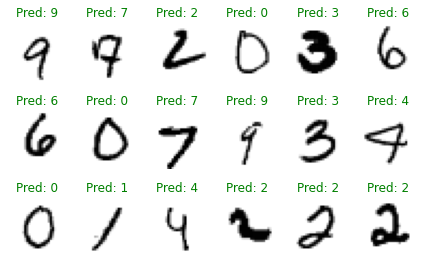

In [ ]:
#plot the images and predicted labels
plot_images(exmp_batch, label_batch, preds,3,6)

In [ ]:
#Then we create the adv images by the pretrained generator with data transformation
perturbation = pretrained_G(exmp_batch.to(device))
perturbation = torch.clamp(perturbation, -0.3, 0.3)
adv_img = exmp_batch.to(device) + perturbation
adv_img = input_diversity(adv_img)
adv_img = torch.clamp(adv_img, 0, 1)
adv_img = transform(adv_img)
y_preds= target_model(adv_img)

In [ ]:
#Also create adv images without data transformation
perturbation = pretrained_G(exmp_batch.to(device))
perturbation = torch.clamp(perturbation, -0.3, 0.3)
adv_img = exmp_batch.to(device) + perturbation
adv_img = torch.clamp(adv_img, 0, 1)
y_preds_= target_model(adv_img)

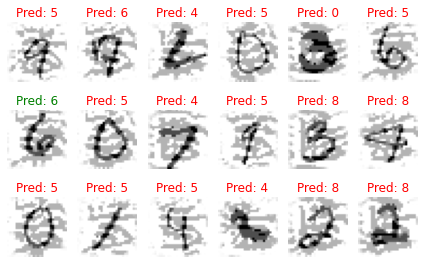

In [ ]:
#plot the adversarial images
with torch.no_grad():
    plot_images(adv_img.to(device),label_batch, y_preds, 3, 6)

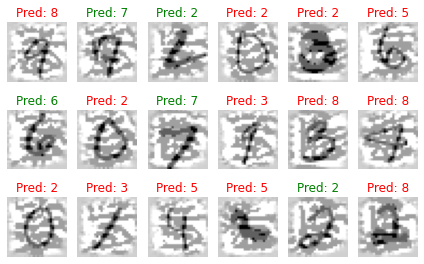

In [ ]:
#plot the adversarial iamges
with torch.no_grad():
    plot_images(exmp_batch.to(device)+perturbation, label_batch,y_preds_,3,6)

Discussion:

Based on the success rate, we could find that the data transformation actually helps to improve the transferability. We could also find the difference between the adversarial images with and without transformation.

However, the work is limited because we have only developed three target models. Two of them are convolutional neural networks, although the architectures are slightly different. It would be more convincing if we build several various target models with different structures to see if it actually works when transfer to other models. In the paper, the authors developed 8 CNN models as their target models. The results demonstrate that it had effectively prevents the generator from overfitting and improves transferability. However, from their results, the data enhancement methods does not work well for some of the target models, but the success rate of some models were really high, which means that this method might not generalize to all models. We may adjust transformations regarding different models to see if we could find few transformation combinations that could generalize to various models.